# Test case for PDEs: Kuramoto-Sivashinksy (KS)

with Mahtab Lak, UNH Math Ph.D. student

### Crank-Nicolson/Adams-Bashforth (CNAB2) timestepping
The Kuramoto-Sivashinsky (KS) equation is a nonlinear time-evolving PDE on a 1d spatial domain.

\begin{equation*}
u_t = -u u_{x} - u_{xx} - u_{xxxx}
\end{equation*}

We will assume a finite domain $[0,L]$ with periodic boundary conditions,
use Fourier modes for spatial discretization and Crank-Nicolson/Adams-Bashforth (CNAB2) timestepping for temporal discretization. 

Write the KS equation as 

\begin{equation*}
u_t = Lu + N(u)
\end{equation*}

where $Lu = - u_{xx} - u_{xxxx}$ is the linear terms and $N(u) = -u u_{x}$ is the nonlinear term. We can also calculate $N$ as $N(

Discretize time by letting $u^n(x) = u(x, n\Delta t)$ for some small $\Delta t$. CNAB2  timestepping approximates  $u_t = Lu + N(u)$ as 

\begin{equation*}
\frac{u^{n+1} - u^n}{\Delta t} = L\left(u^{n+1} + u^n\right) + \frac{3}{2} N(u^n) - \frac{1}{2} N(u^{n-1})
\end{equation*}

Put the unknown future $u^{n+1}$'s on the left and the present $u^{n}$ and past $u^{n+1}$ on the right.

\begin{equation*}
\left(I  - \frac{\Delta t}{2} L \right) u^{n+1} = \left(I  + \frac{\Delta t}{2}L \right) u^{n} + \frac{3 \Delta t}{2} N(u^n) - \frac{\Delta t}{2} N(u^{n-1})
\end{equation*}

Discretize space with a Fourier decomposition, so that $u$ now represents a vector of Fourier coefficients and $L$ turns into  diagonal matrix. Let matrix $A = (I  + \Delta t/2 \; L)$, matrix $B =  (I  - \Delta t/2 \; L)^{-1}$, and let vector $N^n$ be the Fourier transform of a collocation calculation of $N(u^n)$ where

\begin{equation*}
N(u) = -u u_x = -\frac{1}{2} \frac{d}{dx} u^2
\end{equation*}

Then the CNAB2 timestepping formula is

\begin{equation*}
u^{n+1} = B \left(A \, u^n + \frac{3 \Delta t}{2} N^n -  \frac{\Delta t}{2}N^{n-1}\right)
\end{equation*}

This is a simple linear algebra formula whose iteration approximates the time-evolution of the Kuramoto-Sivashinksy PDE. 

### Matlab code for CNAB2 algorithm

We can implement this algorithm in about 40 lines of Matlab code (including comments, whitespace).

```matlab
function [u,x,t] = ksintegrate(u, Lx, dt, Nt, nplot);
% KS eqn: u_t = -u*u_x - u_xx - u_xxxx, periodic BCs 


Nx = length(u);                % number of gridpoints
kx = [0:Nx/2-1 0 -Nx/2+1:-1];  % integer wavenumbers: exp(2*pi*i*kx*x/L)
alpha = 2*pi*kx/Lx;            % real wavenumbers:    exp(i*alpha*x)
D = i*alpha;                   % D = d/dx operator in Fourier space
L = alpha.^2 - alpha.^4;       % linear operator -D^2 - D^3 in Fourier space
G = -0.5*D;                    % -1/2 D operator in Fourier space
NT = floor(Nt/nplot) + 1;      % number of saved time steps
 
x = (0:Nx-1)*Lx/Nx;
t = (0:NT)*dt*nplot;

% some convenience variables
dt2  = dt/2;
dt32 = 3*dt/2;
A =  ones(1,Nx) + dt2*L;
B = (ones(1,Nx) - dt2*L).^(-1);

Nn  = G.*fft(u.*u); % -u u_x, spectral
Nn1 = Nn;        

U(1,:) = u;   % save u(x,0), physical
u = fft(u);   % u, spectral
np = 2;       % n saved,

% timestepping loop
for n = 1:Nt

  Nn1 = Nn;   % shift nonlinear term in time: N^{n-1} <- N^n
  Nn  = G.*fft(real(ifft(u)).^2); % compute Nn = -u u_x

  u = B .* (A .* u + dt32*Nn - dt2*Nn1);
  
  if (mod(n, nplot) == 0)
    U[np, :] = fft(u);
    np = np + 1;
  end
  
end
```

### Naive Julia implementation of CNAB2 algorithm

The Julia code is pretty much a line-by-line translation of the Matlab, same number of lines.

In [4]:
function ksintegrateNaive(u, Lx, dt, Nt, nplot);
    Nx = length(u)                  # number of gridpoints
    kx = vcat(0:Nx/2-1, 0, -Nx/2+1:-1)  # integer wavenumbers: exp(2*pi*i*kx*x/L)
    alpha = 2*pi*kx/Lx              # real wavenumbers:    exp(i*alpha*x)
    D = 1im*alpha                   # D = d/dx operator in Fourier space
    L = alpha.^2 - alpha.^4         # linear operator -D^2 - D^4 in Fourier space
    G = -0.5*D                      # -1/2 D operator in Fourier space
    Nplot = round(Int64, Nt/nplot)+1  # total number of saved time steps
    
    x = collect(0:Nx-1)*Lx/Nx
    t = collect(0:Nplot)*dt*nplot
    U = zeros(Nplot, Nx)
    
    # some convenience variables
    dt2  = dt/2
    dt32 = 3*dt/2
    A =  ones(Nx) + dt2*L
    B = (ones(Nx) - dt2*L).^(-1)

    Nn  = G.*fft(u.*u); # -1/2 d/dx(u^2) = -u u_x, collocation calculation
    Nn1 = Nn;

    U[1,:] = u; # save initial value u to matrix U
    np = 2;     # counter for saved data
    
    # transform data to spectral coeffs 
    u  = fft(u);

    # timestepping loop
    for n = 0:Nt-1
        Nn1 = Nn;                       # shift N^{n-1} <- N^n
        Nn  = G.*fft(real(ifft(u)).^2); # compute N^n = -u u_x

        u = B .* (A .* u + dt32*Nn - dt2*Nn1); # CNAB2 formula
        
        if mod(n, nplot) == 0
            U[np,:] = real(ifft(u))
            np += 1            
        end
    end  
    U,x,t
end

ksintegrateNaive (generic function with 1 method)

### Run the Julia code and plot results

In [5]:
Lx = 128
Nx = 1024
dt = 1/16
nplot = 8
Nt = 1600

x = Lx*(0:Nx-1)/Nx
u = cos(x) + 0.1*cos(x/16).*(1+2*sin(x/16))

U,x,t = ksintegrateNaive(u, Lx, dt, Nt, nplot)
;

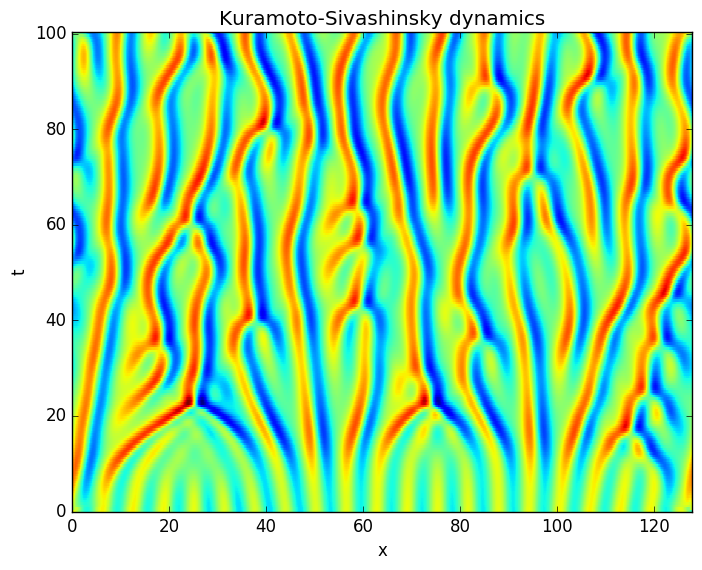


(.:16053): Gtk-WARNING **: Theme parsing error: gtk.css:68:35: The style property GtkButton:child-displacement-x is deprecated and shouldn't be used anymore. It will be removed in a future version

(.:16053): Gtk-WARNING **: Theme parsing error: gtk.css:69:35: The style property GtkButton:child-displacement-y is deprecated and shouldn't be used anymore. It will be removed in a future version

(.:16053): Gtk-WARNING **: Theme parsing error: gtk.css:73:46: The style property GtkScrolledWindow:scrollbars-within-bevel is deprecated and shouldn't be used anymore. It will be removed in a future version

** (.:16053): WARNING **: Couldn't connect to accessibility bus: Failed to connect to socket /tmp/dbus-WMSc4PD06G: Connection refused


PyObject <matplotlib.text.Text object at 0x7f3eaa1e3dd0>

In [6]:
using PyPlot
pcolor(x,t,U)
xlim(x[1], x[end])
ylim(t[1], t[end])
xlabel("x")
ylabel("t")
title("Kuramoto-Sivashinsky dynamics")

### Compare execution times of equivalent KS CNAB2 in various languages

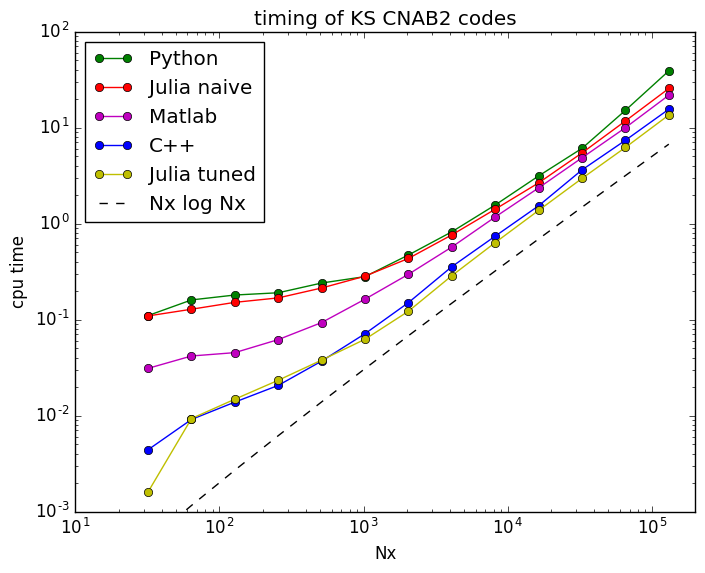

In [7]:
d = readdlm("kstimings.asc")
Nx = d[:,1]
loglog(Nx, d[:,4], "go-", label="Python")
loglog(Nx, d[:,5], "ro-", label="Julia naive")
loglog(Nx, d[:,3], "mo-", label="Matlab")
loglog(Nx, d[:,2], "bo-", label="C++")
loglog(Nx, d[:,6], "yo-", label="Julia tuned")
loglog(Nx, 1e-05*Nx .* log10(Nx), "k--", label="Nx log Nx")
xlabel("Nx")
ylabel("cpu time")
legend(loc="upper left")
xlim(10,2e05)
ylim(1e-03,1e02)
title("timing of KS CNAB2 codes")
;

### Tuned Julia code

The naive Julia code (straight Matlab translation) is slightly slower than Matlab. Can tune the Julia code by 
  * doing FFTs in-place 
  * removing temporary vectors in time-stepping loop
  * using @inbounds and @fastmath macros
  
The tuned Julia code is slightly faster than C++.


In [ ]:
function ksintegrateTuned(u, Lx, dt, Nt);
    u = (1+0im)*u                       # force u to be complex
    Nx = length(u)                      # number of gridpoints
    kx = vcat(0:Nx/2-1, 0:0, -Nx/2+1:-1)# integer wavenumbers: exp(2*pi*kx*x/L)
    alpha = 2*pi*kx/Lx                  # real wavenumbers:    exp(alpha*x)
    D = 1im*alpha                       # spectral D = d/dx operator 
    L = alpha.^2 - alpha.^4             # spectral L = -D^2 - D^4 operator
    G = -0.5*D                          # spectral -1/2 D operator, to eval -u u_x = 1/2 d/dx u^2

    # convenience variables
    dt2  = dt/2
    dt32 = 3*dt/2
    A =  ones(Nx) + dt2*L
    B = (ones(Nx) - dt2*L).^(-1)

    # compute in-place FFTW plans
    FFT! = plan_fft!(u, flags=FFTW.ESTIMATE)
    IFFT! = plan_ifft!(u, flags=FFTW.ESTIMATE)

    # compute uf == Fourier coeffs of u and Nnf == Fourier coeffs of -u u_x
    # FFT!(u);
    Nn  = G.*fft(u.^2); # Nnf == -1/2 d/dx (u^2) = -u u_x, spectral
    Nn1 = copy(Nn);     # use Nnf1 = Nnf at first time step
    FFT!*u;

    # timestepping loop, many vector ops unrolled to eliminate temporary vectors
    for n = 0:Nt

        for i = 1:length(Nn)
            @inbounds Nn1[i] = Nn[i];
            @inbounds Nn[i] = u[i];            
        end

        IFFT!*Nn; # in-place FFT

        for i = 1:length(Nn)
            @fastmath @inbounds Nn[i] = Nn[i]*Nn[i];
        end

        FFT!*Nn;

        for i = 1:length(Nn)
            @fastmath @inbounds Nn[i] = G[i]*Nn[i];
        end

        for i = 1:length(u)
            @fastmath @inbounds u[i] = B[i]* (A[i] * u[i] + dt32*Nn[i] - dt2*Nn1[i]);
        end

    end
    u = real(ifft(u))
end


### CPU time versus lines of source code

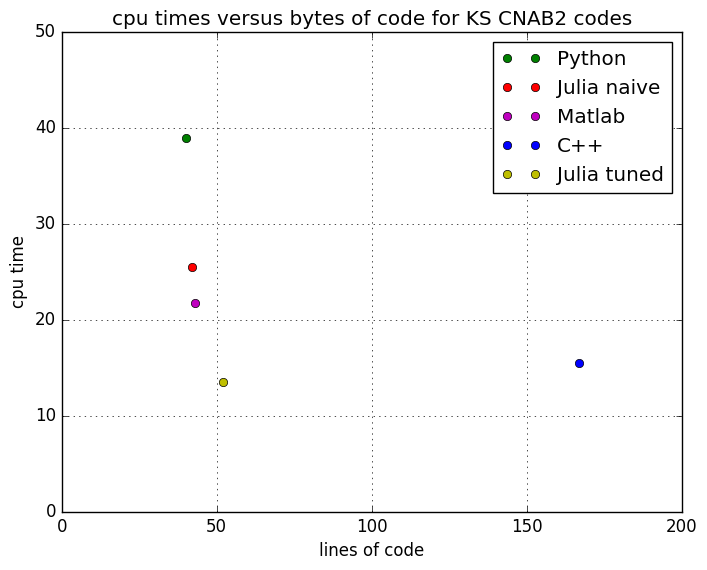

(0,50)

In [10]:
d = readdlm("timeloc.asc")
symbol = ("go", "ro", "mo", "bo", "yo")
language = ("Python", "Julia naive", "Matlab", "C++", "Julia tuned")
for i in 1:5
    plot(d[i,2], d[i,1], symbol[i], label=language[i])
end
legend()
grid("on")
xlabel("lines of code")
ylabel("cpu time")
title("cpu times versus bytes of code for KS CNAB2 codes")
xlim(0,200)
ylim(0,50)
;